#**Pneumonia Image Detection with Machine Learning**



**Big Data Engineering Final Project**

**Course 2024-2025**

Laura Alonso Bartolomé and Abril Moyano Flores

## **1. Introduction**


Pneumonia is a life-threatening disease caused by bacterium that infects the lungs, affecting the normal respiratory process in humans. Each year more than 450 individuals suffer from pneumonia. This disease is prevalent among young children below 5 years old who, according to the report released by "our World in data" (Dadonaite, 2019), have the highest death rate caused by pneumonia (Kareem et al., 2022) (Swetha et al., 2021).

In the past, medical doctors relied on several methods such as clinical examination, medical history and chest X-rays to diagnose patients suffering from this disease. Nowadays, X-rays are commonly used to detect pulmonary diseases, however the lack of experts reduce the detection rate. This problem could be addressed through the use of different computer-aided diagnosis techniques such as machine learning techniques capable of classifying Chest-X-rays images to determine the presence of pneumonia (Kareem et al., 2022).  

The main objective of this project was to develop a machine learning model capable of classifying Chest-X-ray images from healthy patients and patients diagnosed with pneumonia disease. To meet this objective, the methodology was structured into several stages: data preprocessing, training the machine learning model, validation, evaluation and testing of the machine learning model.



## **2. Chest X-Ray Images dataset**

A dataset with Chest-X-ray images from healthy patients and patients suffering from pneumonia was obtained from Kaggle. The data was divided in three directories that contain images from healthy and sick patients for training, validation and testing of the machine learning model. The dataset was first imported using the Kaggle API and then unzipped.

### **2.1. Import necessary dependencies**

In [ ]:
# Import the data
import zipfile
import os

# Data manipulation
import numpy as np
import pandas as pd
import random as rn

# Image manipulation
from PIL import Image

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

# TensorFlow and Keras
import tensorflow
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

### **2.2. Loading the datasets**

In [ ]:
# Connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Coping the kaggle API to Google Colab
!cp "/content/drive/MyDrive/kaggle/kaggle.json" "/content"
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Downloading the data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzziping the data and storing into/tmp
zip_ref = zipfile.ZipFile('chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:21<00:00, 193MB/s]
100% 2.29G/2.29G [00:21<00:00, 113MB/s]


## **3. Methods**

### **3.1. Initiating a Spark season**

In [ ]:
!pip install -q pyspark

In [ ]:
appname = "Final project - Pneumonia Chest X-Ray Images"

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName(appname).master("local[*]").getOrCreate()

### **3.2. Data preprocessing**

First, the images were organized and labeled. The function "process_dir" processes the directories by filtering .jpeg files and storing their file paths along with the corresponding labels in a structured list.

In [ ]:
# Function to process a directory, filter .jpeg files, and add to a list with labels
def process_dir(directory, label, target_list):
    # Process a directory
    for file in os.listdir(directory):
        # Filter .jpeg files
        if file.lower().endswith('.jpeg'):
            # Add path and label to the list
            target_list.append([os.path.join(directory, file), label])

The directories containing the images were processed, and the images were added to their corresponding lists along with a label indicating whether the image belongs to a healthy patient (labeled as 0) or a patient diagnosed with pneumonia (labeled as 1). To ensure a balanced and unbiased distribution, the lists were then shuffled randomly.

In [ ]:
# Defining the paths of the directories that were unzipped
train_normal_dir = '/tmp/chest_xray/train/NORMAL/'
train_pneu_dir = '/tmp/chest_xray/train/PNEUMONIA/'

test_normal_dir = '/tmp/chest_xray/test/NORMAL/'
test_pneu_dir = '/tmp/chest_xray/test/PNEUMONIA/'

val_normal_dir = '/tmp/chest_xray/val/NORMAL/'
val_pneu_dir = '/tmp/chest_xray/val/PNEUMONIA/'

# Initialize lists to store file paths and labels
train_list = []
test_list = []
val_list = []

# Process each directory with appropriate labels, 0 for healthy patients and 1 for patients diagnosed with pneumonia
process_dir(train_normal_dir, 0, train_list)
process_dir(train_pneu_dir, 1, train_list)

process_dir(test_normal_dir, 0, test_list)
process_dir(test_pneu_dir, 1, test_list)

process_dir(val_normal_dir, 0, val_list)
process_dir(val_pneu_dir, 1, val_list)

# Shuffle the lists to randomize the data
rn.shuffle(train_list)
rn.shuffle(test_list)
rn.shuffle(val_list)

Subsequently, the images were preprocesses using the “process_image” function that performs a series of transformations: the images are converted to grey-scale and resized to 224x224 pixels and the pixel values are normalized by dividing by 255, scaling the intensity values to the range [0,1]. The images are then transform into a numpy array to facilitate their manipulation.

In [ ]:
# Images preprocessing
def process_image(img_path, target_size=(224, 224)):
    try:
        # Convert to grayscale
        img = Image.open(img_path).convert('L')
        # Resized to 224x224
        img_resized = img.resize(target_size)
        # Normalize pixel values
        return np.array(img_resized).astype('float32') / 255.0
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

The “compose_dataset_spark” function iterates over the spark dataframes and applies the “process_image” function to each image. The processed images and labels are appended to the the corresponding list and then converted into a NumPy array.

In [ ]:
def compose_dataset_spark(df_spark, target_size=(224, 224)):
    images = []
    labels = []

    for row in df_spark.collect():
        # Apply the process_image function
        img_array = process_image(row.image, target_size)
        if img_array is not None:
            # Append the images to the image list
            images.append(img_array)
            # Append the labels to the label list
            labels.append(row.label)
    # Transform the lists to a numpy array
    images = np.array(images).reshape(-1, target_size[0], target_size[1], 1)
    labels = np.array(labels)

    return images, labels

In [ ]:
# Create Spark DataFrames
train_df = spark.createDataFrame(train_list, ["image", "label"])
test_df = spark.createDataFrame(test_list, ["image", "label"])
val_df = spark.createDataFrame(val_list, ["image", "label"])

# Applying functions to datasets (train, test, validation)
X_train, y_train = compose_dataset_spark(train_df)
X_test, y_test = compose_dataset_spark(test_df)
X_val, y_val = compose_dataset_spark(val_df)

# Print dataset shapes
print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 224, 224, 1), Labels shape: (5216,)
Test data shape: (624, 224, 224, 1), Labels shape: (624,)
Validation data shape: (16, 224, 224, 1), Labels shape: (16,)


### **3.3. Data Visualization**

First, plot the distribution of images classified as pneumonia and normal within all three dataframes.

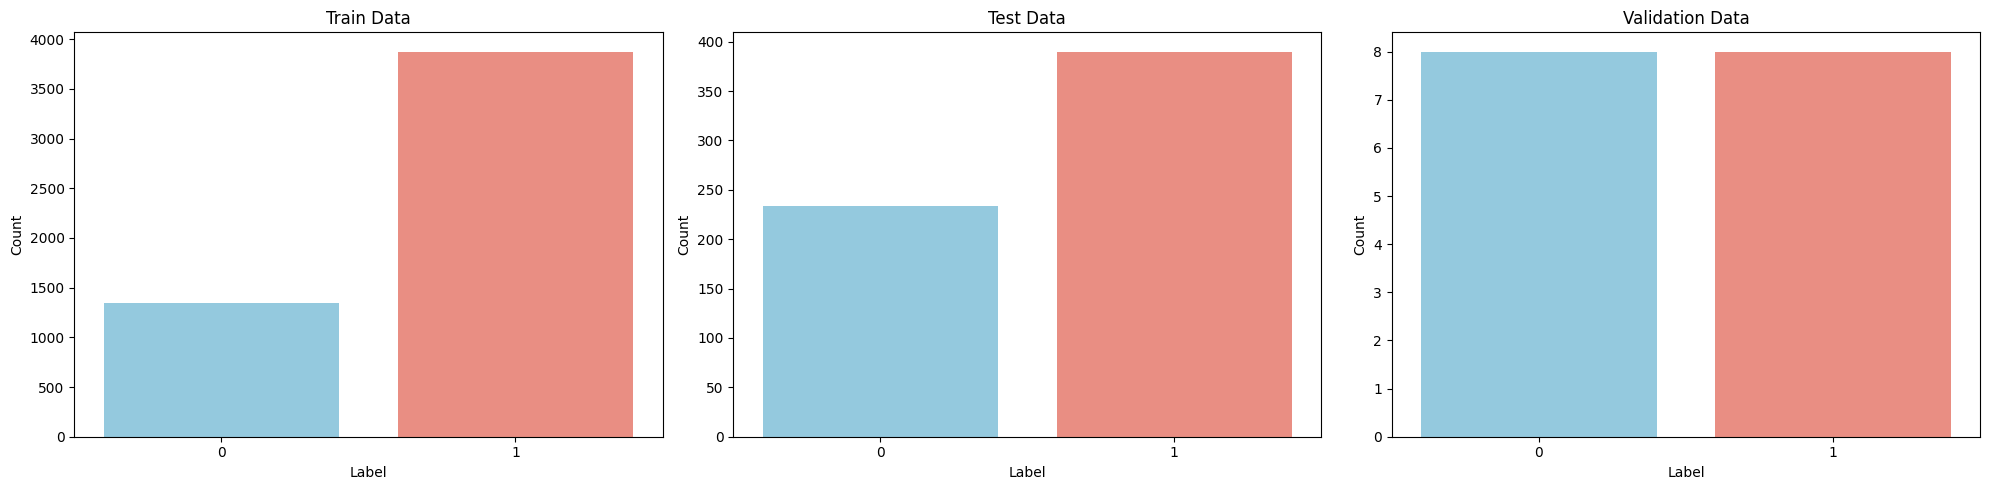

In [ ]:
# Convert PySpark DataFrame to Pandas DataFrame before plotting
train_df_pd = train_df.toPandas()
test_df_pd = test_df.toPandas()
val_df_pd = val_df.toPandas()

plt.figure(figsize=(20, 5))
custom_palette = {0: "skyblue", 1: "salmon"}

# Plot the train dataset
plt.subplot(1, 3, 1)
sns.countplot(x='label', data=train_df_pd, hue='label', palette=custom_palette, legend=False)  # Use Pandas DataFrame here
plt.title('Train Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Plot the test dataset
plt.subplot(1, 3, 2)
sns.countplot(x='label', data=test_df_pd, hue='label', palette=custom_palette, legend=False)  # Use Pandas DataFrame here
plt.title('Test Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Plot the validation dataset
plt.subplot(1, 3, 3)
sns.countplot(x='label', data=val_df_pd, hue='label', palette=custom_palette, legend=False)  # Use Pandas DataFrame here
plt.title('Validation Data')
plt.xlabel('Label')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

**Figure 1**. Number of pneumonia and normal images for each of the three datasets.

The amount of data allocated for validation is really small, only 16 samples. This could affect its efficiency in selecting the best model and, given that there are thousands of images, it doesn't need to be so small. When training the model we will take 15% of the training dataset as a validation set to address this problem.

Visualization of the processed images from the training dataset.

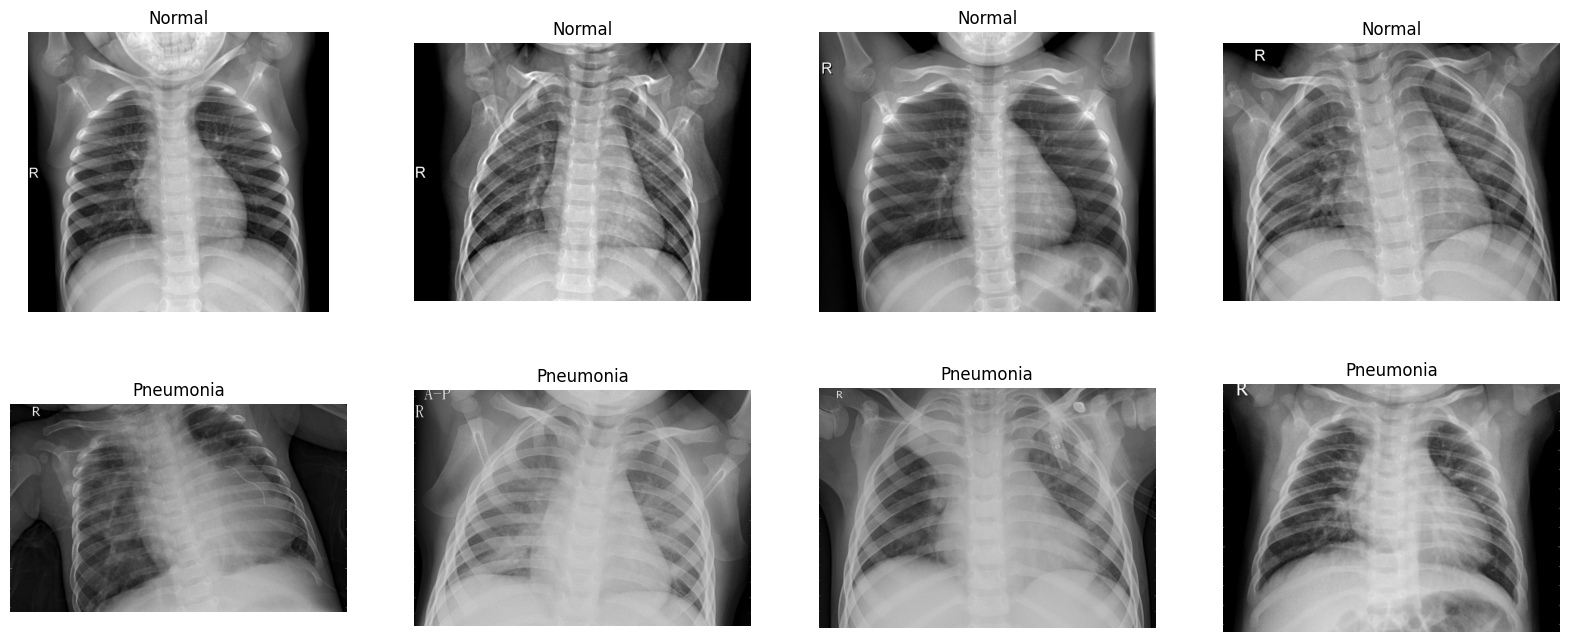

In [ ]:
plt.figure(figsize=(20,8))
for i,img_path in enumerate(train_df_pd[train_df_pd['label'] == 0][0:4]['image']):
    plt.subplot(2,4,i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Normal')

for i,img_path in enumerate(train_df_pd[train_df_pd['label'] == 1][0:4]['image']):
    plt.subplot(2,4,4+i+1)
    plt.axis('off')
    img = plt.imread(img_path)
    plt.imshow(img, cmap='gray')
    plt.title('Pneumonia')

**Figure 2. Processed Chest-X-Ray images obtained from the train dataset**. The top row display images of healthy patients (labeled 'Normal'), while the bottom row shows x-rays of patients diagnosed with pneumonia (labeled 'Pneumonia')

### **3.4. Building the model**

In [ ]:
# Transform labels to categorical.
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

A convolutional neural network (CNN) model is defined using the Keras Sequential API.

In [ ]:
model = Sequential([
    # First convolutional layer with 32 3x3 filters
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)),
    # Reduction of the image size to half
    MaxPooling2D((2, 2)),
    # Second convolutional layer with 64 3x3 filters
    Conv2D(64, (3, 3), activation='relu'),
    # Reduction of the image size
    MaxPooling2D((2, 2)),
    # Transform the output of the last convolutional layer into a one-dimensional vector
    Flatten(),
    # Dense layer with 128 neurons
    Dense(128, activation='relu'),
    # Dropout to reduce overfitting
    Dropout(0.5),
    # Dense layer with two neurons (Normal and Pneumonia)
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The training is done using callbacks that will save a checkpoint of the model at the end of each epoch on Google Drive and stop early if validation loss stops decreasing to avoid overfitting.

In [ ]:
batch_size = 128
epochs = 10

callbacks = [
    # The model is saved after each epochs
    keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/Big Data/model_at_epoch_{epoch}.keras"),
    # If val_loss does not improve in 3 consecutive epochs the training stops
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]
# Training the model
model.fit(
    X_train,
    y_train,
    # Use 15% of the training data for validation
    validation_split=0.15,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)
# Model evaluation
score = model.evaluate(X_test, y_test, verbose=0)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 453s 12s/step - accuracy: 0.6958 - loss: 1.3429 - val_accuracy: 0.9068 - val_loss: 0.2275
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 479s 14s/step - accuracy: 0.9293 - loss: 0.1772 - val_accuracy: 0.9553 - val_loss: 0.1289
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 469s 13s/step - accuracy: 0.9552 - loss: 0.1194 - val_accuracy: 0.9681 - val_loss: 0.1041
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 504s 13s/step - accuracy: 0.9654 - loss: 0.0996 - val_accuracy: 0.9655 - val_loss: 0.1071
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 470s 12s/step - accuracy: 0.9648 - loss: 0.0905 - val_accuracy: 0.9693 - val_loss: 0.0908
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 450s 12s/step - accuracy: 0.9772 - loss: 0.0693 - val_accuracy: 0.9706 - val_loss: 0.0851
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 426s 12s/step - accuracy: 0.9788 - loss: 0.0616 - val_accuracy: 0.9642 - val_loss: 0.1021
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 457s 13s/step - accuracy: 0.9789 - loss: 0.0601 - val_accuracy: 0.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71,721,224 (273.59 MB)

 Trainable params: 23,907,074 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,814,150 (182.40 MB)

The final model is saved to drive. This is important because when a colab runtime disconects all of its data is lost. By saving the model it just has to be trained once and be loaded back to use it again when reconnecting to colab.

In [ ]:
model.save("/content/drive/MyDrive/Colab Notebooks/Big Data/final_model.keras")

In [ ]:
model = keras.saving.load_model("/content/drive/MyDrive/Colab Notebooks/Big Data/final_model.keras")

### **3.5. Model Evaluation**

In [ ]:
predictions = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 834ms/step


----------------------------------- Results -----------------------------------
   Actual  Prediction
0       1           1
1       1           1
2       0           1
3       1           1
4       0           1


----------------------------- Error and Accuracy ------------------------------
Training classification error: 0.0165
Training accuracy: 0.9835
Test classification error: 0.2260
Test accuracy: 0.7740


--------------------------- Classification Report -----------------------------
Classification report:

               precision    recall  f1-score   support

           0       0.94      0.42      0.58       234
           1       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.71       624
weighted avg       0.82      0.77      0.75       624



------------------------------ Confusion Matrix -------------------------------


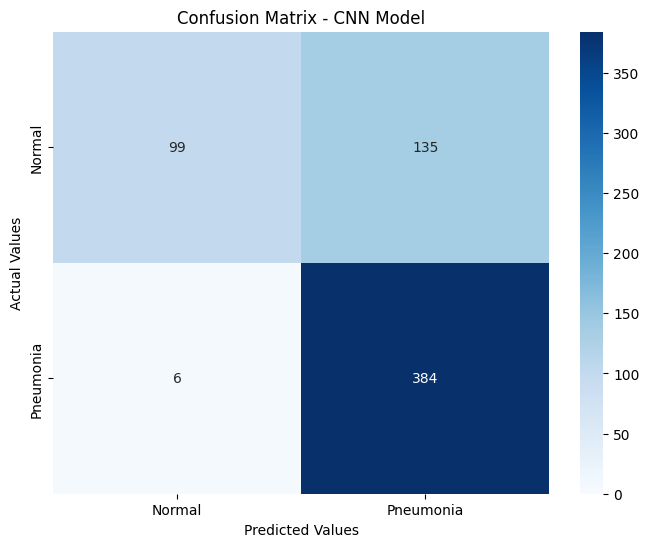

In [ ]:
y_pred = np.argmax(predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

results = pd.DataFrame({'Actual': y_true, 'Prediction': y_pred})

print('----------------------------------- Results -----------------------------------')
print(results.head())

print('\n')

print('----------------------------- Error and Accuracy ------------------------------')

# Calculate classification errors and accuracy
y_train_pred = np.argmax(model.predict(X_train), axis=1)
train_error = np.mean(y_train_pred != np.argmax(y_train, axis=1))
test_error = np.mean(y_true != y_pred)

train_accuracy = accuracy_score(np.argmax(y_train, axis=1), y_train_pred)
test_accuracy = accuracy_score(y_true, y_pred)

print(f'Training classification error: {train_error:.4f}')
print(f'Training accuracy: {train_accuracy:.4f}')
print(f'Test classification error: {test_error:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')

print('\n')

print('--------------------------- Classification Report -----------------------------')

# Classification report with precision and recall metrics
print('Classification report:\n\n', classification_report(y_true, y_pred))

print('\n')

print('------------------------------ Confusion Matrix -------------------------------')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'],
            norm=mcolors.Normalize(vmin=0, vmax=np.max(conf_matrix)))

plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

The classification reports provide several interesting metrics including precision (which measures the quality of positive predictions), recall (which assesses the completeness of positive predictions), and the F1-score (the harmonic mean of precision and recall)

The model shows a 94% of precision for the class 0 ("Normal") and 74% precision for the class 1 ("Pneumonia") indicating that only 74% of the images classified as "Pneumonia" were correctly labeled. On the other hand, the model shows a recall of 42% and 98% for class 0 and class 1 respectively, indicating that only 42% of the "Normal" images were classified as such.

This indicates that the model tends to overestimate the likelihood of Pneumonia based on the images.

A confusion matrix was generates to provide a visual representation of the results.

## **4. Conclusions**

The model shows a very high accuracy on the training set (98.35), however, its performance declines significantly on the test set (77.40). This behaviour is a clear indicator of overfitting to the training set.

The model demonstrate a high precision (94%) and an extremely low recall (42%) for class 0 (“Normal”) meaning it correctly identifies only 42% of the real normal cases while misclassifies the remaining as pneumonia. Conversely, for the class 1 (“Pneumonia”), the model achieves a high recall (98%) and a lower precision (74%), indicating that while it correctly detects nearly all pneumonia cases, a high proportion of images classified as pneumonia actually belong to normal patients. This highlight a strong tendency to overpredict pneumonia.

The model performance could be enhanced by balancing the number of pneumonia and normal images. Currently the dataset contains more pneumonia images than normal images which may cause the model to overpredict pneumonia cases. Moreover, hyperparameter tunning, such as experimenting with different learning rates or batch sizes, could improve the model generalization reducing overfitting.


# **PONER LA EVALUACIÓN**

## **5. References**

Dadonaite, B. (2019). Pneumonia — no child should die from a disease we can prevent. Our World In Data. https://ourworldindata.org/child-deaths-from-pneumonia

Kareem, A., Liu, H. & Sant, P. Review on Pneumonia Image Detection: A Machine Learning Approach. Hum-Cent Intell Syst 2, 31–43 (2022). https://doi.org/10.1007/s44230-022-00002-2

Swetha, K., M, N., P, A. M., & M, M. Y. (2021). Prediction of Pneumonia Using Big Data, Deep Learning and Machine Learning Techniques. 2022 7th International Conference On Communication And Electronics Systems (ICCES). https://doi.org/10.1109/icces51350.2021.9489188
